# NLP Project: Review Sentiment Analysis for BestBuy

This project performs a **comprehensive sentiment analysis** on customer reviews of *BestBuy* collected from **Trustpilot**. The workflow includes **data collection**, **storage in MongoDB**, **text cleaning**, **sentiment classification** using multiple models, **aspect-based sentiment analysis (ABSA)**, **topic modeling and clustering**, and **sentiment trend visualization**.  

The analysis provides actionable insights into **customer satisfaction**, highlighting strengths and weaknesses across different service aspects such as delivery, price, quality, and overall service.

## Data Collection 
Fetch reviews from Trustpilot, handling multiple pages efficiently.

In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    NoSuchElementException,
    StaleElementReferenceException,
    ElementClickInterceptedException,
)
from pymongo import MongoClient
import time

# MongoDB setup
client = MongoClient("mongodb://localhost:27017/")
db = client["trustpilot"]
collection = db["bestbuy_reviews"]

# Selenium setup
url = "https://ca.trustpilot.com/review/bestbuy.ca"
driver = webdriver.Chrome()
driver.get(url)
wait = WebDriverWait(driver, 10)

all_reviews = []

def scrape_reviews():
    """Scrape reviews from current page."""
    wait.until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "article[class*='styles_reviewCard__']"))
    )
    reviews = driver.find_elements(By.CSS_SELECTOR, "article[class*='styles_reviewCard__']")
    page_reviews = []
    for r in reviews:
        try:
            reviewer = r.find_element(By.CSS_SELECTOR, "span[class*='styles_consumerName__']").text
            rating = r.find_element(By.CSS_SELECTOR, "img[class*='CDS_StarRating_starRating__']").get_attribute("alt")
            text = r.find_element(By.CSS_SELECTOR, "p[class*='CDS_Typography_body-l__']").text
            date = r.find_element(By.CSS_SELECTOR, "time").get_attribute("datetime")
            
            review_data = {
                "reviewer": reviewer,
                "rating": rating,
                "text": text,
                "date": date
            }
            page_reviews.append(review_data)
        except Exception:
            continue
    return page_reviews

page = 1
while True:
    print(f"Fetching page {page}...")
    # Scroll to load all reviews
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    
    # Scrape reviews on current page
    page_reviews = scrape_reviews()
    all_reviews.extend(page_reviews)
    collection.insert_many(page_reviews)  # save to MongoDB immediately
    
    # Try to click next page
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, "a[aria-label='Next page']")
        # Check if button is disabled (grey)
        if next_button.get_attribute("aria-disabled") == "true":
            print("Reached last page.")
            break
        
        driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
        time.sleep(1)
        try:
            next_button.click()
        except (ElementClickInterceptedException, StaleElementReferenceException):
            driver.execute_script("arguments[0].click();", next_button)
        page += 1
        time.sleep(5)  # wait for next page to load
    except NoSuchElementException:
        print("Next page button not found, ending loop.")
        break

driver.quit()
print(f"Scraped and saved {len(all_reviews)} reviews in MongoDB!")

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Fetching page 41...
Fetching page 42...
Fetching page 43...
Fetching page 44...
Fetching page 45...
Fetching page 46...
Fetching page 47...
Fetching page 48...
Fetching page 49...
Fetching page 50...
Fetching 

## Load data from MongoDB

In [21]:
from pymongo import MongoClient
import pandas as pd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["trustpilot"]
collection = db["bestbuy_reviews"]

# Load data into DataFrame
data = pd.DataFrame(list(collection.find()))
print(f"Loaded {len(data)} reviews")
data.head()

Loaded 1733 reviews


,_id,reviewer,rating,text,date
0,68ae27fba80982fba0b36597,Charlotte Elder,Rated 1 out of 5 stars,DO NOT BUY APPLIANCES FROM BEST BUY - total ni...,2025-08-21T20:05:59.000Z
1,68ae27fba80982fba0b36598,Zuzika Hoare,Rated 1 out of 5 stars,"Ordered Iphone watch on July 27th, received co...",2025-08-19T17:27:48.000Z
2,68ae27fba80982fba0b36599,Craig,Rated 1 out of 5 stars,I paid $900 for a brand-new TV and the deliver...,2025-08-22T00:39:04.000Z
3,68ae27fba80982fba0b3659a,HOPPY T,Rated 5 out of 5 stars,We had an issue with the Brevelle Microwave co...,2025-08-18T03:32:52.000Z
4,68ae27fba80982fba0b3659b,nadia,Rated 1 out of 5 stars,they will steal your money; ordered a camera a...,2025-08-24T06:24:38.000Z


## Preprocess text

In [24]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\b(best[-\s]?buy)\b", "COMPANY", text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()

[nltk_data] Downloading package stopwords to /Users/kt1u1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,_id,reviewer,rating,text,date,clean_text
0,68ae27fba80982fba0b36597,Charlotte Elder,Rated 1 out of 5 stars,DO NOT BUY APPLIANCES FROM BEST BUY - total ni...,2025-08-21T20:05:59.000Z,buy appliances total nightmare stand behind pr...
1,68ae27fba80982fba0b36598,Zuzika Hoare,Rated 1 out of 5 stars,"Ordered Iphone watch on July 27th, received co...",2025-08-19T17:27:48.000Z,ordered iphone watch july 27th received confir...
2,68ae27fba80982fba0b36599,Craig,Rated 1 out of 5 stars,I paid $900 for a brand-new TV and the deliver...,2025-08-22T00:39:04.000Z,paid 900 brandnew tv delivery disgrace drivers...
3,68ae27fba80982fba0b3659a,HOPPY T,Rated 5 out of 5 stars,We had an issue with the Brevelle Microwave co...,2025-08-18T03:32:52.000Z,issue brevelle microwave combi warranty repair...
4,68ae27fba80982fba0b3659b,nadia,Rated 1 out of 5 stars,they will steal your money; ordered a camera a...,2025-08-24T06:24:38.000Z,steal money ordered camera almost month ago pe...


## Sentiment Analysis

Three models were used:

TextBlob – rule-based model.
DistilBERT SST-2 – transformer-based classifier.
Multilingual BERT – the most accurate model.

In [142]:
# =========================================
# Method 1: TextBlob (lexicon-based)
# =========================================
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity  # -1 to 1
    if polarity > 0.2:
        return "positive"
    elif polarity < -0.2:
        return "negative"
    else:
        return "neutral"

data['sentiment_textblob'] = data['clean_text'].apply(get_sentiment_textblob)


In [110]:
data['sentiment_textblob'].value_counts()

sentiment_textblob
neutral     1206
negative     305
positive     222
Name: count, dtype: int64

In [111]:
# =========================================
# Method 2: DistilBERT SST-2 (binary: positive/negative)
# =========================================
bert_binary = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True
)

data['sentiment_distilbert'] = data['clean_text'].apply(
    lambda x: bert_binary(x[:512])[0]['label'].lower()  # only take first 512 tokens
)


In [112]:
data['sentiment_distilbert'].value_counts()

sentiment_distilbert
negative    1662
positive      71
Name: count, dtype: int64

In [113]:
# =========================================
# Method 3: Multilingual BERT (1–5 stars → collapsed)
# =========================================
bert_multi = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

def map_multibert(text):
    result = bert_multi(text[:512])[0]['label']  # e.g., "1 star"
    stars = int(result.split()[0])
    if stars <= 2:
        return "negative"
    elif stars == 3:
        return "neutral"
    else:
        return "positive"

data['sentiment_multibert'] = data['clean_text'].apply(map_multibert)


In [114]:
data['sentiment_multibert'].value_counts()

sentiment_multibert
negative    1573
neutral       85
positive      75
Name: count, dtype: int64

In [115]:
# =========================================
# Domain-specific override
# =========================================
domain_negatives = [
    "steal your money", "scam", "fraud", "ripoff",
    "cheated", "cheating", "warranty sucks", "worst company",
    "stole my money", "fake product", "never buy again"
]

def apply_domain_override(row):
    text = row['clean_text']
    for kw in domain_negatives:
        if kw in text:
            return "negative"
    return row['sentiment_multibert']  # fallback

data['sentiment_domain'] = data.apply(apply_domain_override, axis=1)

In [116]:
data['sentiment_domain'].value_counts()

sentiment_domain
negative    1573
neutral       85
positive      75
Name: count, dtype: int64

In [117]:
# =========================================
# Ground truth from rating
# =========================================
def rating_to_sentiment(rating_str):
    try:
        # Match "Rated X out of 5 stars" → extract X
        match = re.search(r"Rated\s+(\d+)\s+out", str(rating_str))
        if match:
            rating = int(match.group(1))
        else:
            return "neutral"
    except:
        return "neutral"
    
    if rating >= 4:
        return "positive"
    elif rating <= 2:
        return "negative"
    else:
        return "neutral"

data['rating_sentiment'] = data['rating'].apply(rating_to_sentiment)
data['rating_sentiment'].value_counts()

rating_sentiment
negative    1541
positive     174
neutral       18
Name: count, dtype: int64

In [118]:
from IPython.display import display, HTML

display(HTML('''
<style>
/* Increase the height of the scrollable output area */
.output_scroll {
    height: 1000px !important;
}
</style>
'''))


=== Evaluation for sentiment_textblob ===
Accuracy: 0.26 | Precision: 0.55 | Recall: 0.54 | F1: 0.35
              precision    recall  f1-score   support

    negative       0.99      0.20      0.33      1541
     neutral       0.01      0.61      0.02        18
    positive       0.64      0.82      0.72       174

    accuracy                           0.26      1733
   macro avg       0.55      0.54      0.35      1733
weighted avg       0.94      0.26      0.36      1733



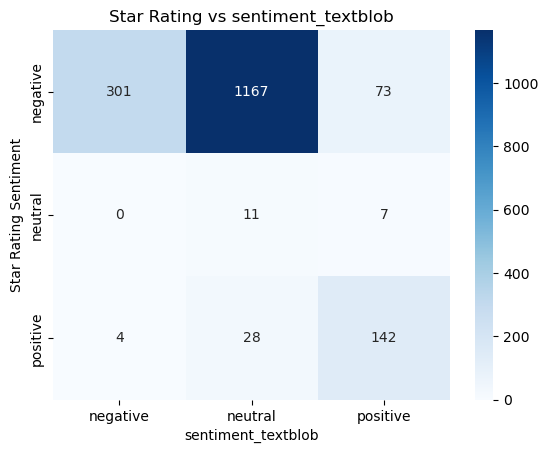


=== Evaluation for sentiment_distilbert ===
Accuracy: 0.92 | Precision: 0.57 | Recall: 0.44 | F1: 0.47
              precision    recall  f1-score   support

    negative       0.92      0.99      0.96      1541
     neutral       0.00      0.00      0.00        18
    positive       0.80      0.33      0.47       174

    accuracy                           0.92      1733
   macro avg       0.57      0.44      0.47      1733
weighted avg       0.90      0.92      0.90      1733



/Users/kt1u1/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kt1u1/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kt1u1/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kt1u1/anaconda3/lib/python3.11/sit

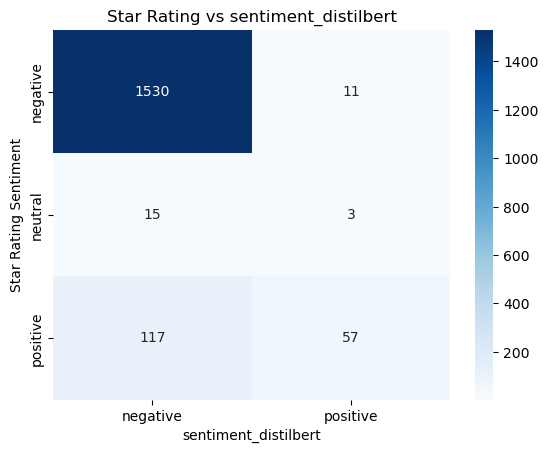


=== Evaluation for sentiment_multibert ===
Accuracy: 0.92 | Precision: 0.62 | Recall: 0.53 | F1: 0.52
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      1541
     neutral       0.05      0.22      0.08        18
    positive       0.84      0.36      0.51       174

    accuracy                           0.92      1733
   macro avg       0.62      0.53      0.52      1733
weighted avg       0.95      0.92      0.92      1733



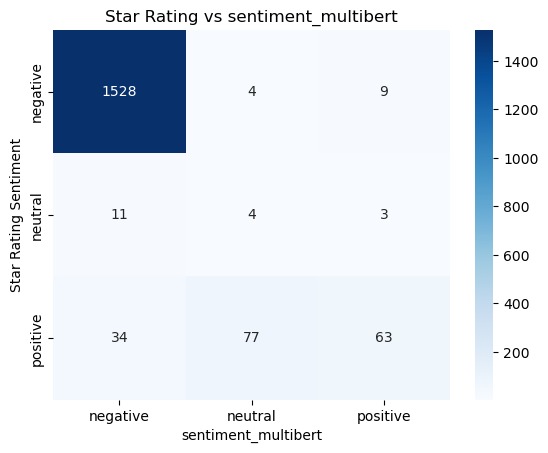


=== Evaluation for sentiment_domain ===
Accuracy: 0.92 | Precision: 0.62 | Recall: 0.53 | F1: 0.52
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      1541
     neutral       0.05      0.22      0.08        18
    positive       0.84      0.36      0.51       174

    accuracy                           0.92      1733
   macro avg       0.62      0.53      0.52      1733
weighted avg       0.95      0.92      0.92      1733



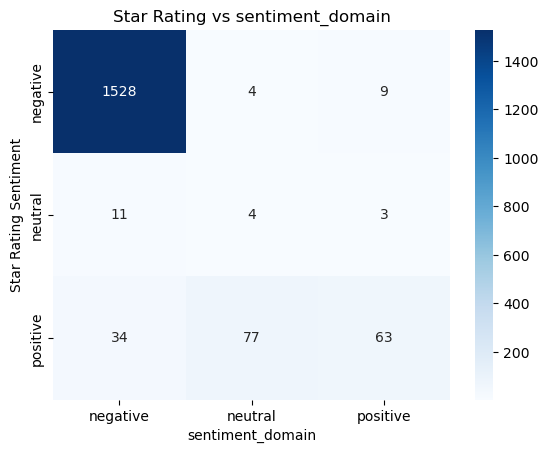


Examples where domain override helps:
                                                                       text  \
179   The order shipped and it was acceptable given all the problems wit...   
297   Best Buy is great for selling products, not too knowledgeable thou...   
762   I would review my product, but you need a functional website to pu...   
1023  Are you serious? We have to wait to shop on your online store. You...   

     sentiment_multibert sentiment_domain  
179              neutral          neutral  
297              neutral          neutral  
762              neutral          neutral  
1023             neutral          neutral  


In [108]:
# =========================================
# Evaluation of each method vs star ratings
# =========================================
methods = ["sentiment_textblob", "sentiment_distilbert", "sentiment_multibert", "sentiment_domain"]

for m in methods:
    print(f"\n=== Evaluation for {m} ===")
    df_eval = data.dropna(subset=['rating_sentiment', m])
    acc = accuracy_score(df_eval['rating_sentiment'], df_eval[m])
    prec = precision_score(df_eval['rating_sentiment'], df_eval[m], average='macro')
    rec = recall_score(df_eval['rating_sentiment'], df_eval[m], average='macro')
    f1 = f1_score(df_eval['rating_sentiment'], df_eval[m], average='macro')
    
    print(f"Accuracy: {acc:.2f} | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")
    print(classification_report(df_eval['rating_sentiment'], df_eval[m]))

    # Confusion matrix
    comparison = pd.crosstab(df_eval['rating_sentiment'], df_eval[m])
    sns.heatmap(comparison, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Star Rating vs {m}")
    plt.xlabel(f"{m}")
    plt.ylabel("Star Rating Sentiment")
    plt.show()

# =========================================
# Inspect example misclassifications
# =========================================
print("\nExamples where domain override helps:")
bad_cases = data[(data['rating_sentiment']=="negative") & (data['sentiment_multibert']=="neutral")]
print(bad_cases[['text','sentiment_multibert','sentiment_domain']].head(10))

## Aspect-Based Sentiment Analysis (ABSA) 

In [119]:
import re
from transformers import pipeline
import pandas as pd

# -------------------------
# Define a regex-based sentence splitter
# -------------------------
def split_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text)

# -------------------------
# Define aspects and keywords
# -------------------------
aspect_keywords = {
    "delivery": [
        "delivery", "shipping", "ship", "arrived", "arrival", "dispatch", "sent",
        "late", "delay", "delayed", "slow", "on time", "punctual", "fast", "quick",
        "next day", "prime", "tracking", "package", "parcel", "courier", "lost", "damaged"
    ],
    "price": [
        "price", "cost", "expensive", "overpriced", "cheap", "reasonable", "affordable",
        "deal", "bargain", "discount", "offer", "worth", "value", "money", "pricing",
        "rip off", "fair", "unfair"
    ],
    "quality": [
        "quality", "durable", "sturdy", "fragile", "broken", "defective", "faulty",
        "performance", "functionality", "features", "design", "build", "materials",
        "craftsmanship", "usability", "long lasting", "wear out", "poorly made", "well made"
    ],
    "service": [
        "service", "support", "staff", "representative", "agent", "helpful", "unhelpful",
        "friendly", "rude", "polite", "knowledgeable", "response", "responsiveness",
        "warranty", "return", "refund", "customer service", "after sales", "assistance",
        "problem solved", "issue", "call center"
    ]
}

# -------------------------
# Setup Multilingual BERT sentiment pipeline
# -------------------------
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

def classify_sentiment(text):
    """
    Map 1-5 stars to negative/neutral/positive
    """
    result = sentiment_pipeline(text[:512])[0]['label']  # truncate to first 512 tokens
    stars = int(result.split()[0])
    if stars <= 2:
        return "negative"
    elif stars == 3:
        return "neutral"
    else:
        return "positive"

# -------------------------
# ABSA: assign sentiment per aspect
# -------------------------
def aspect_sentiment(review_text):
    """
    For a given review, return a dict with aspect -> sentiment
    """
    review_sentences = split_sentences(review_text)
    aspect_sentiments = {aspect: [] for aspect in aspect_keywords.keys()}

    for sentence in review_sentences:
        sentence_lower = sentence.lower()
        for aspect, keywords in aspect_keywords.items():
            if any(kw in sentence_lower for kw in keywords):
                # classify sentiment for this sentence
                sentiment = classify_sentiment(sentence)
                aspect_sentiments[aspect].append(sentiment)

    # Aggregate: if multiple sentences per aspect, take majority
    aggregated_sentiments = {}
    for aspect, sentiments in aspect_sentiments.items():
        if len(sentiments) == 0:
            aggregated_sentiments[aspect] = None  # no mention
        else:
            aggregated_sentiments[aspect] = max(set(sentiments), key=sentiments.count)
    return aggregated_sentiments

# -------------------------
# Apply ABSA to your dataset
# -------------------------
# Create new columns for each aspect
for aspect in aspect_keywords.keys():
    data[aspect + "_sentiment"] = None

# Iterate over rows
for idx, row in data.iterrows():
    absa_result = aspect_sentiment(row['text'])
    for aspect in aspect_keywords.keys():
        data.at[idx, aspect + "_sentiment"] = absa_result[aspect]

# -------------------------
# Example: view ABSA results
# -------------------------
print(data[['text','delivery_sentiment','price_sentiment','quality_sentiment','service_sentiment']].head(10))

# -------------------------
# Aggregate results for visualization
# -------------------------
aspect_summary = {}
for aspect in aspect_keywords.keys():
    aspect_summary[aspect] = data[aspect + "_sentiment"].value_counts(dropna=True)

print("\nAspect Sentiment Summary:")
for aspect, counts in aspect_summary.items():
    print(f"\n{aspect}:\n{counts}")

                                                                    text  \
0  DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do ...   
1  Ordered Iphone watch on July 27th, received confirmation July 28th...   
2  I paid $900 for a brand-new TV and the delivery was a disgrace. Th...   
3  We had an issue with the Brevelle Microwave combi that under warra...   
4  they will steal your money; ordered a camera almost a month ago an...   
5  I purchased a Samsung fridge from BestBuy online, and had it deliv...   
6  I paid $900 for a brand-new TV and the delivery was a disgrace. Th...   
7  DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do ...   
8                                                       Crooked Best Buy   
9  Ordered Iphone watch on July 27th, received confirmation July 28th...   

  delivery_sentiment price_sentiment quality_sentiment service_sentiment  
0               None            None              None              None  
1           n

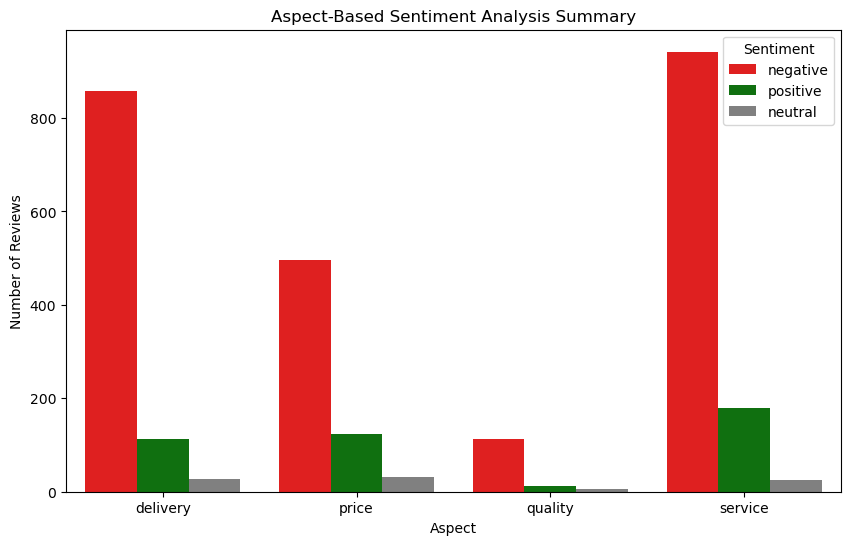

In [120]:
# =============================
# Prepare data for plotting
# =============================
plot_data = []
for aspect, counts in aspect_summary.items():
    for sentiment, count in counts.items():
        plot_data.append({
            "aspect": aspect,
            "sentiment": sentiment,
            "count": count
        })

plot_df = pd.DataFrame(plot_data)

# =============================
# Plot
# =============================
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x='aspect', y='count', hue='sentiment', 
            palette={'positive':'green','neutral':'gray','negative':'red'})
plt.title("Aspect-Based Sentiment Analysis Summary")
plt.xlabel("Aspect")
plt.ylabel("Number of Reviews")
plt.legend(title='Sentiment')
plt.show()

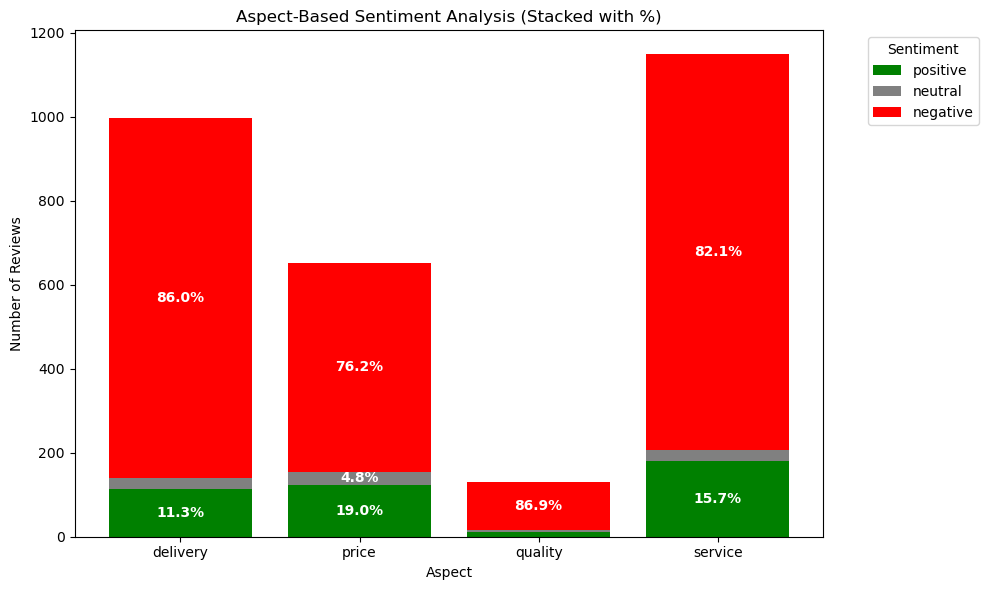

In [121]:
import matplotlib.pyplot as plt
import pandas as pd

# Define colors for sentiment
colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

# Prepare data: get counts of each sentiment per aspect
stacked_df = pd.DataFrame({
    'delivery': aspect_summary['delivery'],
    'price': aspect_summary['price'],
    'quality': aspect_summary['quality'],
    'service': aspect_summary['service']
}).fillna(0)

# Ensure order of sentiment for stacking
stacked_df = stacked_df.reindex(['positive','neutral','negative'])

# Calculate percentages
percent_df = stacked_df.div(stacked_df.sum(axis=0), axis=1) * 100

# Plot
fig, ax = plt.subplots(figsize=(10,6))
bottom = [0]*len(stacked_df.columns)

min_bar_height_for_label = 30  # adjust this threshold as needed

for sentiment in stacked_df.index:
    ax.bar(stacked_df.columns, stacked_df.loc[sentiment], 
           bottom=bottom, color=colors[sentiment], label=sentiment)
    
    # Add percentage labels
    for i, aspect in enumerate(stacked_df.columns):
        val = stacked_df.loc[sentiment, aspect]
        pct = percent_df.loc[sentiment, aspect]
        
        # Only show label if bar segment is tall enough
        if val > min_bar_height_for_label:
            ax.text(i, bottom[i] + val/2, f"{pct:.1f}%", 
                    ha='center', va='center', color='white', fontweight='bold')
    
    bottom = [bottom[j] + stacked_df.loc[sentiment, stacked_df.columns[j]] 
              for j in range(len(bottom))]

ax.set_title("Aspect-Based Sentiment Analysis (Stacked with %)")
ax.set_xlabel("Aspect")
ax.set_ylabel("Number of Reviews")
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [130]:
import pandas as pd

# Show full text in pandas output
pd.set_option('display.max_colwidth', 70)

# Define positive customers if any aspect is positive or overall rating_sentiment is positive
positive_customers = data[
    (data['rating_sentiment'] == 'positive') |
    (data['delivery_sentiment'] == 'positive') |
    (data['price_sentiment'] == 'positive') |
    (data['quality_sentiment'] == 'positive') |
    (data['service_sentiment'] == 'positive')
]

# Show positive customers with full text
print(positive_customers[['text','rating_sentiment','delivery_sentiment','price_sentiment','quality_sentiment','service_sentiment']].head(10))

                                                                     text  \
3   We had an issue with the Brevelle Microwave combi that under warra...   
6   I paid $900 for a brand-new TV and the delivery was a disgrace. Th...   
10  We had an issue with the Brevelle Microwave combi that under warra...   
13  5-10 years ago this company used to employ knowledgeable staff. No...   
15  I JUST BOUGHT A SEGWAY NINEBOT C2 E SCOOTER AND IT WORKS PERFECTLY...   
18  I purchased the DeLorean DM-200 e-bike from BestBuy in June 2024. ...   
27  We had an issue with the Brevelle Microwave combi that under warra...   
30  I paid $900 for a brand-new TV and the delivery was a disgrace. Th...   
34  We had an issue with the Brevelle Microwave combi that under warra...   
37  5-10 years ago this company used to employ knowledgeable staff. No...   

   rating_sentiment delivery_sentiment price_sentiment quality_sentiment  \
3          positive               None            None              None   


In [131]:
# Define neutral if all aspects are neutral or None
pd.set_option('display.max_colwidth', 80)

neutral_customers = data[
    ((data['delivery_sentiment'] == 'neutral') | (data['delivery_sentiment'].isna())) &
    ((data['price_sentiment'] == 'neutral') | (data['price_sentiment'].isna())) &
    ((data['quality_sentiment'] == 'neutral') | (data['quality_sentiment'].isna())) &
    ((data['service_sentiment'] == 'neutral') | (data['service_sentiment'].isna()))
]

# Example: Show neutral customers
print(neutral_customers[['text','rating','delivery_sentiment','price_sentiment','quality_sentiment','service_sentiment']].head(10))

                                                                               text  \
0   DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do not stand ...   
7   DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do not stand ...   
8                                                                  Crooked Best Buy   
14  ordered two separate large ticket items that said in stock. Bow orders cance...   
15  I JUST BOUGHT A SEGWAY NINEBOT C2 E SCOOTER AND IT WORKS PERFECTLY, VERY PLE...   
24  DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do not stand ...   
31  DO NOT BUY APPLIANCES FROM BEST BUY - total nightmare and they do not stand ...   
32                                                                 Crooked Best Buy   
38  ordered two separate large ticket items that said in stock. Bow orders cance...   
39  I JUST BOUGHT A SEGWAY NINEBOT C2 E SCOOTER AND IT WORKS PERFECTLY, VERY PLE...   

                    rating delivery_sentim

## Topic Modeling & Clustering
### For discovering hidden themes in reviews (what customers really talk about)

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert reviews into term-document matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['clean_text'])

# Fit LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words per topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:",
          [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0: ['phone', 'time', 'days', 'store', 'told', 'online', 'delivery', 'customer', 'service', 'order']
Topic 1: ['experience', 'said', 'damage', 'washer', 'store', 'warranty', 'bought', 'dryer', 'buy', 'appliances']
Topic 2: ['service', 'invoice', 'disgrace', 'brought', 'paid', 'truck', 'apartment', 'said', 'tv', 'delivery']
Topic 3: ['online', 'dont', 'laptop', 'time', 'phone', 'said', 'service', 'customer', 'told', 'store']
Topic 4: ['cancel', 'credit', 'shipped', 'received', 'ordered', 'called', 'aug', 'delivery', 'order', 'july']


## Sentiment Trend Over Time (by Month)

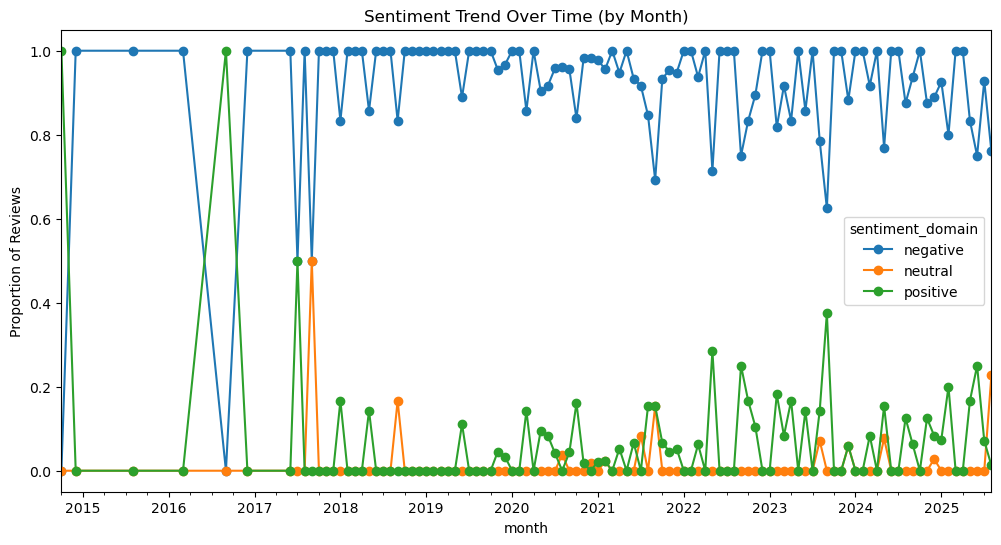

In [141]:
import matplotlib.pyplot as plt

# Convert ISO timestamp string to datetime
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.to_period('M')

# Example: trend using domain sentiment (more reliable)
trend = data.groupby('month')['sentiment_domain'].value_counts(normalize=True).unstack().fillna(0)

# Plot
trend.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Sentiment Trend Over Time (by Month)")
plt.ylabel("Proportion of Reviews")
plt.show()